<a href="https://colab.research.google.com/github/nicholasfurl/Great-Courses/blob/main/Lesson15_vgg16CNN_bugs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##########
#-----vgg16 DCNN bug versus animal classification
#This notebook trains an image classification model and makes gradual improvements, 
#debugging the model, to improve performance. GPUs are encouraged. 
#In colab, one can add a GPU by clicking the Runtime menu and selecting Change runtime type. 
#Selecting GPU as the hardware accelerator will allow for the usage of a GPU.
#########

In [1]:
#Download tinyImageNet
#200 categories, 500 images per category, images 64*64*3

#unzipping creates a tiny-imagenet-200 folder in active directory with test, train and val subfolders and two *.txt files
#Train subfolders have lots of further subfolders, eacj labveled n10*. Within each is some text files and an images folder
#containing n*.JPEG images
#Test subfolder has subfolder images with test_*JPEG files
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2023-01-03 18:09:02--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  35.8MB/s    in 9.0s    

2023-01-03 18:09:11 (26.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
!pip install keras=='2.8.0'
#from PIL import Image    #I knpow from previous lessons that this doesn't work
import keras.utils as image #This is the one that works
from keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.8.0 which is incompatible.


In [3]:
#specify folder names  (for training set?)
cats_0 = ['n01443537','n01629819','n01641577','n01644900','n01698640','n01742172',
          'n01855672','n01882714','n02002724','n02056570','n02058221','n02074367',
          'n02085620','n02094433','n02099601','n02099712','n02106662','n02113799',
          'n02123045','n02123394','n02124075','n02125311','n02129165','n02132136',
          'n02364673','n02395406','n02403003','n02410509','n02415577','n02423022',
          'n02437312','n02480495','n02481823','n02486410','n02504458','n02509815']
cats_1 = ['n01770393','n01774384','n01774750','n01784675','n02165456','n02190166',
          'n02206856','n02226429','n02231487','n02233338','n02236044','n02268443',
          'n02279972','n02281406']

In [4]:
#function def to read files and return training and test sets

#the cats argument will be one of the 
def read_cats(cats, lab, train_size, test_size):

  #initialise stuff for loop
  vecs = []
  labs = []

  num_images_per_folder = 500 #a bit more explanatory and robust than it was

  #loop through each folder name (a subcategory of animals or bugs) and then through the images in that folder
  for c in cats:  #folder names from argument
    for i in range(num_images_per_folder): #num images per folder`

    #load the image and convert it to an array
      img = image.load_img("tiny-imagenet-200/train/"+c+"/images/"+c+"_"+str(i)+".JPEG")
      img_arr = image.img_to_array(img)
      

      #vectorise then reshape? This appears to vectorise it and then just put it back as it was again! Why?
      #print(c, i, img_arr.shape) 
      img_arr = img_arr.flatten() #this is numpy not image
      #print(c, i, img_arr.shape)
      img_arr = img_arr.reshape(64,64,3)
      #print(c, i, img_arr.shape)

      
      vecs += [img_arr] #Accumulates 2D arrays? Or should it be vectorised?
      labs += [lab]   #But this will just be [] every time? Something's not right here ....

  vecs = np.asarray(vecs) #convert to array

  #Split into train and test sets and then return
  return(train_test_split(vecs,labs, train_size=train_size,test_size=test_size))  #train size and test_size arguments are used here!

In [26]:
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, .1, .2) #So hand it the animals (category 0), make its label 0, and train size will be .1 and test_size will be .2. 
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, .1, .2)
#print(X0_train.shape) #1800*64*64*3 is what I want? According to the lecture, yes.
#print(y0_train)  #1800 0's is what I want? Yes, you gave lab as an argument so one run will be handed 0o and the other 1.

#Put all training examples together and all test examples together
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

In [6]:
#Build vgg16 model!

#Only the function definition

def build_network():

  #Are these importations only local if defined within a function?
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Activation, Dropout, Flatten
  from keras.layers import Conv2D
  from keras.layers import MaxPooling2D


  input_shape = (64, 64, 3)
  #Instantiate an empty model
  model = Sequential()
  model.add(Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) #Final sigmoid function allows binary classification (like logistic regression - what do I use for multiway classification?)
  
  return(model)

In [27]:
#Run model! 

#Do I need GPU? With GPU was only a few seconds

#model is a "sequential" object

#Result is supposed to be disappointing. 
#Loss is .28 (a bit high) and accuracy is only .72
#So remaining blocks are meant to debug

#I guess this specifies it
model = build_network()
#And this runs it? No, this "configures" it
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#No, this runs it!
model.fit(X_train,y_train, validation_data=(X_test,y_test))

79/79 [==============================] - 8s 93ms/step - loss: 0.2799 - accuracy: 0.7196 - val_loss: 0.2800 - val_accuracy: 0.7200


In [41]:
#I want to verify for myself that predictions are always one category

#Don't forget: X are image pixels and y are labels!!

#confusion matrix (rows truth, cols model predictions)
yhat = model.predict(X_test)

#yhat
print(yhat)

#Python has a unique in numpy!
unique, counts = np.unique(yhat, return_counts=True)

print(unique)
print(counts)

#Did it! So 5000 0's indeed



[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[0.]
[5000]


3699
1


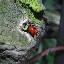

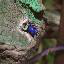

In [24]:
#Now to debug / improve performance

#Let's look at images in the dataset
import random
#from keras.preprocessing import image #I think keras.utils is needed, but it was already imported earlier anyway
from keras.applications.vgg16 import preprocess_input

#generate random integer between 0 and 4999 (length of y_test - 1) 
#So we can get an index into y_test and X_test (which starts with 0 in Python!)
i = random.randint(0,len(y_test)-1)

print(i)  #the index (into X_test to get the image pixels)
print(y_test[i])  #the label for the image in X test (0 or 1)

#Get image (a bit strange to use y to define random number and then index into X instead!)
img_arr = X_test[i]

#without preprocessing
img = image.array_to_img(img_arr)
display(img)

#with preprocessing
img_arr = preprocess_input(img_arr)
img = image.array_to_img(img_arr)
display(img)

#Should we not have preprocessed everything before submission to model? Or is that done within the fit code?

#Preprocessing really changes the colours!


In [42]:
#We now rerun the model by balancing the number of examples from cats_1 and cats_0. 
#We include 500 examples of each category in the training set and the tets set.
#We retrain the model and report the new accuracy on the train and test set.

#Only took a few seconds

# running again with balanced examples
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 500, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 500, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, validation_data=(X_test,y_test))

#The result is that performance now looks much worse. Because it was previously getting 72% always guessing the 72% majority category all the time. Now it can't get by guessing anymore

32/32 [==============================] - 3s 80ms/step - loss: 0.4952 - accuracy: 0.4940 - val_loss: 0.5000 - val_accuracy: 0.5000
